In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai pymongo[srv]==3.12

In [1]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

## Define tools

In [2]:
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from pymongo import MongoClient
from datetime import datetime

import os
import json
from bson import json_util

# Define tools
@tool
def get_sales_data(query: dict = None):
    """Get sales data from MongoDB using flexible query parameters.
    
    Args:
        query: Custom MongoDB query dict to execute directly
    """    
    
    mongo_query = query
    
    uri = os.getenv("MONGODB_URI")
    if not uri:
        return "Error: MongoDB URI not found in environment variables"
        
    try:
        client = MongoClient(uri)
        database = client.get_database("mongodbVSCodePlaygroundDB")
        collection = database.get_collection("sales")
        
        # Execute the query with options
        cursor = collection.find(mongo_query)
        sales_data = list(cursor)
        
        # Convert results to a readable format (handle MongoDB ObjectId and Date objects)
        results = json.loads(json_util.dumps(sales_data))
        
        client.close()
        
        if not sales_data:
            return f"No sales found for query: {mongo_query}"  
        
        return {
            "count": len(sales_data),
            "query": mongo_query,
            "sales": results
        }
    
    except Exception as e:
        return f"Error retrieving sales data: {str(e)}"

In [3]:
from langchain_core.messages import AIMessage

# Create a tool node with the get_sales_data tool
tool_node = ToolNode([get_sales_data])

# Test with a query for 2014 sales
query = {'item': 'xyz'}

print("\nMethod using AIMessage with tool calls")
tool_call_message = AIMessage(
    content="",
    tool_calls=[
        {
            "id": "1",
            "type": "function",
            "name": "get_sales_data",
            "args": {
                "query": query
            }
        }
    ]
)

result = tool_node.invoke({"messages": [tool_call_message]})
print("Tool node result: " + str(result))


Method using AIMessage with tool calls
Tool node result: {'messages': [ToolMessage(content='{"count": 2, "query": {"item": "xyz"}, "sales": [{"_id": {"$oid": "6837860f55e9e6698ee5a770"}, "item": "xyz", "price": 5, "quantity": 10, "date": {"$date": "2014-03-15T09:00:00Z"}}, {"_id": {"$oid": "6837860f55e9e6698ee5a771"}, "item": "xyz", "price": 5, "quantity": 20, "date": {"$date": "2014-04-04T11:21:39.736Z"}}]}', name='get_sales_data', tool_call_id='1')]}
Tool node result: {'messages': [ToolMessage(content='{"count": 2, "query": {"item": "xyz"}, "sales": [{"_id": {"$oid": "6837860f55e9e6698ee5a770"}, "item": "xyz", "price": 5, "quantity": 10, "date": {"$date": "2014-03-15T09:00:00Z"}}, {"_id": {"$oid": "6837860f55e9e6698ee5a771"}, "item": "xyz", "price": 5, "quantity": 20, "date": {"$date": "2014-04-04T11:21:39.736Z"}}]}', name='get_sales_data', tool_call_id='1')]}


## Define MongoDB Query Agent

In [4]:
from typing import Literal
from langchain_openai import AzureChatOpenAI
from langgraph.types import Command

def mongo_query_agent(state) -> Command[Literal["__end__"]]:
    """Agent that processes user queries about sales data and uses LLM to generate a mongo query based on schema."""
    
    # Extract the user message
    user_message = state["messages"][-1].content
    
    # Define the MongoDB schema for the LLM
    schema_info = """
    MongoDB Collection Schema:
    {
        'item': string,      // Product identifier like 'abc', 'xyz', etc.
        'price': number,     // Price of the item (e.g., 10, 7.5)
        'quantity': number,  // Number of items sold (e.g., 5, 10)
        'date': Date     // Date of the sale in ISO format 
    }
    """

    # Create system prompt for the LLM
    system_prompt = f"""
        You are a MongoDB query assistant. Based on user requests, generate appropriate MongoDB queries.
        {schema_info}

        Analyze the user query, determine what information they need from the sales data, and formulate a MongoDB query dictionary.
        Your response should be a valid Python dictionary that can be used as a MongoDB query.
        
        For example, if the user asks about sales in 2014, you might return: 
        {{'date': {{'$gte': datetime(2014, 1, 1), '$lt': datetime(2015, 1, 1)}}}}
        
        If they ask about an item 'xyz', you might return:
        {{'item': 'xyz'}}
        
        Be specific and precise with your queries.
        """

    # Call the LLM to analyze the user query
    llm = AzureChatOpenAI(
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
        openai_api_version="2024-12-01-preview",
    )
    
    chat_prompt = [{"role": "system", "content": system_prompt}, 
                  {"role": "user", "content": f"Generate a MongoDB query for: {user_message}"}]
    
    llm_response = llm.invoke(chat_prompt)
    query_str = llm_response.content
    
    print("Generated MongoDB query:", query_str)
    
    # Return the result with a tool call to get_sales_data
    return {"messages": state["messages"] + [AIMessage(
        content="",
        tool_calls=[
            {
                "id": "1",
                "type": "function",
                "name": "get_sales_data",
                "args": {
                    "query": eval(query_str)  # Convert string representation to dict
                }
            }
        ]
    )]}

## build the graph

In [5]:
from langgraph.graph import StateGraph, MessagesState, START

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("mongo_query_agent", mongo_query_agent)
builder.add_node("tool_executor", tool_node)

builder.add_edge(START, "mongo_query_agent")
builder.add_edge("mongo_query_agent", "tool_executor")
builder.add_edge("tool_executor", "__end__")

network = builder.compile()

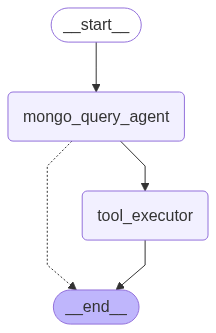

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        network.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [7]:
# Test the agent with some example queries
from langchain_core.messages import HumanMessage

# Example: Query for a specific item in 2014
response = network.invoke({"messages": [HumanMessage(content="How many xyz items were sold in 2014?")]})
print("\nQuery Response:")
print(response["messages"][-1].content)

Generated MongoDB query: ```python
{
    'item': 'xyz',
    'date': {
        '$gte': datetime(2014, 1, 1),
        '$lt': datetime(2015, 1, 1)
    }
}
```


SyntaxError: invalid syntax (<string>, line 1)